In [ ]:
from voxnet import VoxNetAutoEncoder, EnhancedVoxNetAutoEncoder
import torch
from data.modelnet10 import ModelNet10
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

model_path = 'denoise/denoise_model_49.pth'
data_root = 'data/ModelNet10'
CLASSES = {
    0: 'bathtub',
    1: 'chair',
    2: 'dresser',
    3: 'night_stand',
    4: 'sofa',
    5: 'toilet',
    6: 'bed',
    7: 'desk',
    8: 'monitor',
    9: 'table'
}
N_CLASSES = len(CLASSES)

train_dataset = ModelNet10(data_root=data_root, n_classes=N_CLASSES, idx2cls=CLASSES, split='train')
test_dataset = ModelNet10(data_root=data_root, n_classes=N_CLASSES, idx2cls=CLASSES, split='test')

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

voxnet = EnhancedVoxNetAutoEncoder(z_dim=1024)

{'bathtub': 0, 'chair': 1, 'dresser': 2, 'night_stand': 3, 'sofa': 4, 'toilet': 5, 'bed': 6, 'desk': 7, 'monitor': 8, 'table': 9}
{'bathtub': 0, 'chair': 1, 'dresser': 2, 'night_stand': 3, 'sofa': 4, 'toilet': 5, 'bed': 6, 'desk': 7, 'monitor': 8, 'table': 9}


In [14]:
def visualize_voxel(voxel):
    xs, ys, zs = np.where(voxel[0] > 0)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, c='blue', marker='s')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Sampled Point Cloud')
    ax.set_xlim([4, 28])
    ax.set_ylim([4, 28])
    ax.set_zlim([4, 28])
    plt.show()

In [15]:
voxnet.load_state_dict(torch.load(model_path))

RuntimeError: Error(s) in loading state_dict for EnhancedVoxNetAutoEncoder:
	size mismatch for fc_enc.weight: copying a param with shape torch.Size([1024, 65536]) from checkpoint, the shape in current model is torch.Size([256, 65536]).
	size mismatch for fc_enc.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc_dec.weight: copying a param with shape torch.Size([65536, 1024]) from checkpoint, the shape in current model is torch.Size([65536, 256]).

In [4]:
# noise function
def add_salt_pepper_noise(voxel, noise_ratio = 0.05):
    mask = np.random.choice(2, size=voxel.size(), p=[1 - noise_ratio, noise_ratio])
    indices = np.where(mask)
    voxel[indices] = 1 - voxel[indices]
    return voxel

def add_occlusion_noise(voxel, block_size=10, n_blocks=1):
    for _ in range(n_blocks):
        x = np.random.randint(5, 28 - block_size)
        y = np.random.randint(5, 28 - block_size)
        z = np.random.randint(5, 28 - block_size)
        voxel[:, :, x:x+block_size, y:y+block_size, z:z+block_size] = 0
    return voxel

In [5]:
sample = next(iter(test_dataloader))
voxel = sample['voxel'].float()

noised_voxel = voxel.detach().clone()
noised_voxel = add_salt_pepper_noise(noised_voxel)
noised_voxel = add_occlusion_noise(noised_voxel)

In [6]:
recon_voxel = voxnet(noised_voxel)

In [ ]:
import torch
import torch.nn.functional as F
import math

def rotate_voxels(voxels, angles_deg):
    """
    voxels: (B, 1, D, H, W) float tensor (e.g., on GPU)
    angles_deg: list or tensor of shape (B,) with rotation angles in degrees
    returns: rotated voxels of shape (B, 1, D, H, W)
    """
    B, C, X, Y, Z = voxels.shape
    device = voxels.device

    voxels = voxels.permute(0, 1, 4, 2, 3)
    
    # 正規化された座標に対する2D回転行列（Z軸回転）
    theta = []
    for angle in angles_deg:
        rad = math.radians(angle)
        cos = math.cos(rad)
        sin = math.sin(rad)

        # 3D affine行列（バッチごとに定義）
        # Z軸回転なので X-Y平面に回転行列を適用、Zはそのまま
        mat = torch.tensor([
            [cos, -sin, 0, 0],
            [sin,  cos, 0, 0],
            [0,    0,   1, 0]
        ], dtype=torch.float32, device=device)
        theta.append(mat)

    theta = torch.stack(theta)  # (B, 3, 4)

    # `affine_grid` expects normalized coordinates in [-1, 1]
    grid = F.affine_grid(theta, size=voxels.size(), align_corners=True)  # (B, D, H, W, 3)

    # grid_sample: 3Dボクセルに対する補間付きサンプリング
    rotated = F.grid_sample(voxels, grid, align_corners=True, mode='nearest', padding_mode='zeros')
    rotated = rotated.permute(0, 1, 3, 4, 2)
    return rotated


In [139]:
ratated_voxel = rotate_voxels_z_torch(voxel, torch.rand(32) * 360)

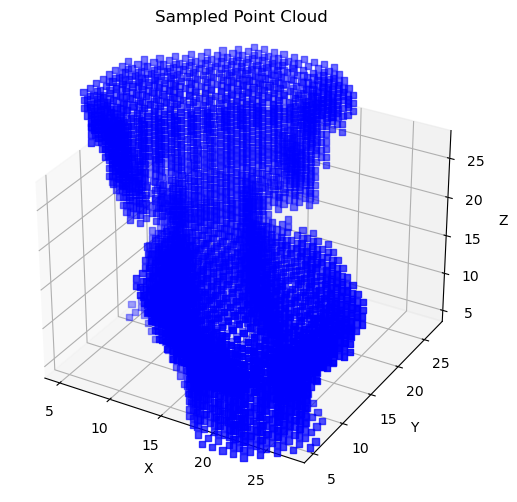

In [140]:
visualize_voxel(ratated_voxel[4])

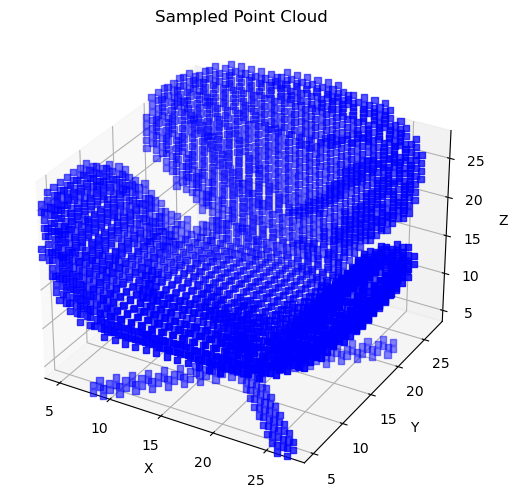

In [10]:
visualize_voxel(voxel[1])    

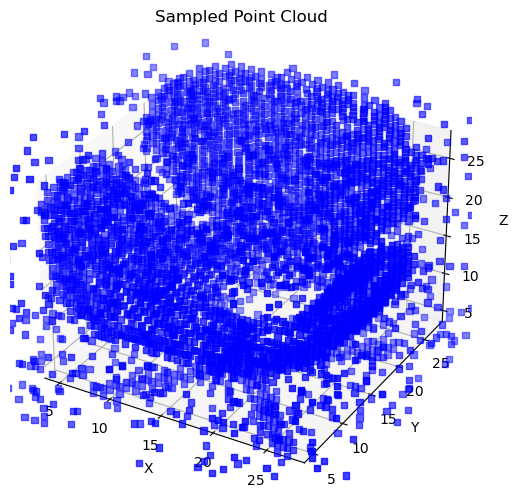

In [11]:
visualize_voxel(noised_voxel[1])

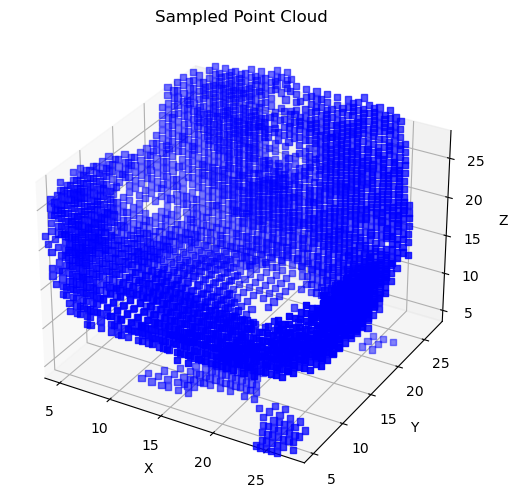

In [12]:
visualize_voxel((recon_voxel[1] > 0.5).float())

In [ ]:
choices = np.random.randint(0, 4, (32, ))
noised_voxel = voxel.detach().clone()
noised_voxel[((choices == 1) | (choices == 3))] = add_salt_pepper_noise(noised_voxel[(choices==1) | (choices == 3)])
noised_voxel[((choices == 2) | (choices == 3))] = add_occlusion_noise(noised_voxel[((choices == 2) | (choices == 3))])

In [175]:
choices

array([0, 2, 0, 0, 3, 2, 3, 2, 2, 3, 0, 1, 0, 1, 0, 0, 1, 3, 2, 0, 3, 0,
       2, 3, 0, 2, 3, 1, 2, 2, 1, 3])

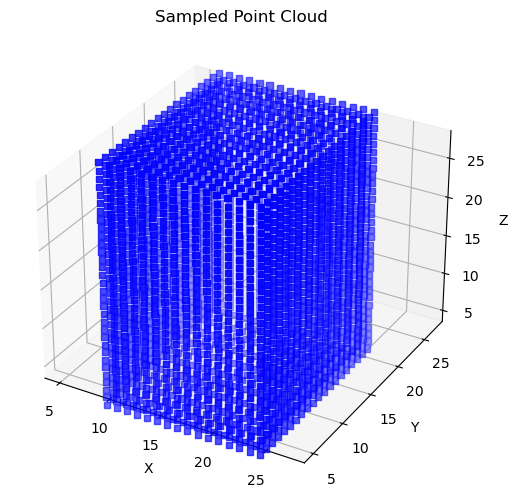

In [180]:
visualize_voxel(voxel[-2])

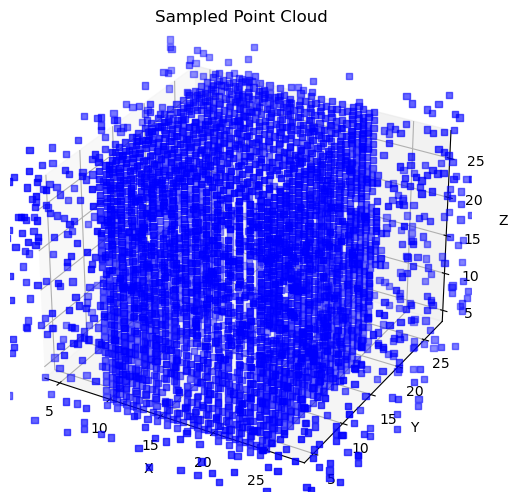

In [181]:
visualize_voxel(noised_voxel[-2])